In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/data
No --configs argument given - defaulting to:
/Users/josephbullock/Documents/covidmodelling/JUNE/june/configs


2022-01-04 15:14:05,141 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/camp_data
2022-01-04 15:14:05,142 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [5]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-01-04 15:14:05,499 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [6]:
# populate empty world
populate_world(world)

In [7]:
# distribute people to households
distribute_people_to_households(world)

In [8]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-01-04 15:14:06,252 - hospitals - INFO - There are 8 hospitals in the world.


In [9]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-01-04 15:14:06,285 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-01-04 15:14:06,306 - social_venue - INFO - Domain 0 has 509 play_groups(s)
2022-01-04 15:14:06,312 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-01-04 15:14:06,348 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-01-04 15:14:06,372 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-01-04 15:14:06,874 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-01-04 15:14:06,883 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-01-04 15:14:06,896 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [10]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['m', 'f', 'm', 'm', 'f'], [22, 26, 52, 55, 50])

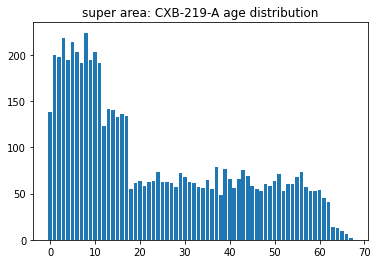

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

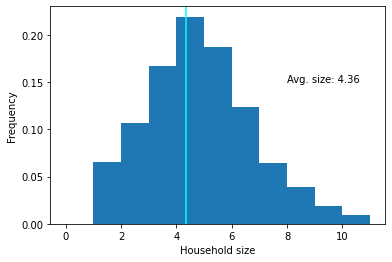

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [20]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

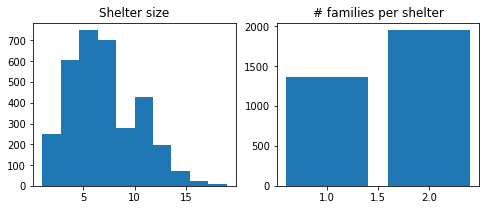

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [22]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [23]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [24]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [25]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [26]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [27]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [28]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [29]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [30]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [31]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [32]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [33]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [34]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [35]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [36]:
selector = InfectionSelector.from_file()

In [37]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [38]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [39]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [40]:
policies.policies

# Set comorbidities

Set initial comorbidities to people in this world. The input "comorbidities.csv" files are age-based probability matrix.

In [ ]:
comorbidity_data = load_comorbidity_data(
    camp_data_path / "input/demography/myanmar_male_comorbidities.csv",
    camp_data_path / "input/demography/myanmar_female_comorbidities.csv",
)
for person in world.people:
    person.comorbidity = generate_comorbidity(person, comorbidity_data)

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [41]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [42]:
infection_seeds = InfectionSeeds([infection_seed])

In [43]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path=camp_configs_path / "defaults/comorbidities.yaml",
    male_comorbidity_reference_prevalence_path= camp_data_path / "input/demography/uk_male_comorbidities.csv",
    female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv",
    
)

In [44]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [45]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [46]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-01-04 15:14:08,436 - leisure - INFO - Linking households and care homes for visits
2022-01-04 15:14:08,437 - leisure - INFO - Done
2022-01-04 15:14:08,437 - leisure - INFO - Distributing social venues to areas
2022-01-04 15:14:08,437 - leisure - INFO - Distributed in 0 of 65 areas.
2022-01-04 15:14:08,523 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [47]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [48]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [49]:
%%time
simulator.run()

2022-01-04 15:14:08,842 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2022-01-04 15:14:09,362 - rank - INFO - Next timestep
2022-01-04 15:14:09,362 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:09,563 - rank - INFO - Rank 0 -- move_people -- 0.20034429399999887
2022-01-04 15:14:09,564 - rank - INFO - Rank 0 -- move_people_waiting -- 4.2499999999279225e-06
2022-01-04 15:14:09,564 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.019999999409606e-06,3.0994415283203125e-06 - 2020-05-24 00:00:00
2022-01-04 15:14:09,570 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 254
2022-01-04 15:14:09,643 - rank - INFO - Rank 0 -- interaction -- 0.07861998599999964
2022-01-04 15:14:09,645 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004365100000001121,0.0004353523254394531 - 2020-05-24 00:00:00
2022-01-04 15:14:0

2022-01-04 15:14:14,264 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 298
2022-01-04 15:14:14,391 - rank - INFO - Rank 0 -- interaction -- 0.1332040069999998
2022-01-04 15:14:14,394 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005056560000014088,0.0005052089691162109 - 2020-05-25 02:00:00
2022-01-04 15:14:14,426 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0580999999731944e-05
2022-01-04 15:14:14,440 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013928724999999531,0.013928890228271484 - 2020-05-25 02:00:00

2022-01-04 15:14:14,441 - rank - INFO - Next timestep
2022-01-04 15:14:14,442 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:14,968 - rank - INFO - Rank 0 -- move_people -- 0.5254290679999993
2022-01-04 15:14:14,969 - rank - INFO - Rank 0 -- move_people_waiting -- 9.869000001216932e-06
2022-01-04 15:14:14,970 - activity_manager - INFO - CMS: Peopl

2022-01-04 15:14:19,096 - rank - INFO - Next timestep
2022-01-04 15:14:19,097 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:19,659 - rank - INFO - Rank 0 -- move_people -- 0.5609784950000005
2022-01-04 15:14:19,660 - rank - INFO - Rank 0 -- move_people_waiting -- 7.509999999655292e-06
2022-01-04 15:14:19,660 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.399000001598097e-06,4.0531158447265625e-06 - 2020-05-26 06:00:00
2022-01-04 15:14:19,667 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 424
2022-01-04 15:14:19,814 - rank - INFO - Rank 0 -- interaction -- 0.15334241400000082
2022-01-04 15:14:19,820 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0012640899999993849,0.001264333724975586 - 2020-05-26 06:00:00
2022-01-04 15:14:19,859 - rank - INFO - Rank 0 -- interaction_waiting -- 9.934000001265986e-06
2022-01-04 15:14:19,874 - simulator - INFO - CMS: T

2022-01-04 15:14:24,478 - rank - INFO - Rank 0 -- interaction -- 0.15006260599999877
2022-01-04 15:14:24,484 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0010031169999997758,0.0010018348693847656 - 2020-05-27 08:00:00
2022-01-04 15:14:24,518 - rank - INFO - Rank 0 -- interaction_waiting -- 9.332000001194274e-06
2022-01-04 15:14:24,533 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01464781900000034,0.014648914337158203 - 2020-05-27 08:00:00

2022-01-04 15:14:24,535 - rank - INFO - Next timestep
2022-01-04 15:14:24,535 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:24,757 - rank - INFO - Rank 0 -- move_people -- 0.22128877699999805
2022-01-04 15:14:24,758 - rank - INFO - Rank 0 -- move_people_waiting -- 4.728000000397969e-06
2022-01-04 15:14:24,759 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0920000000378423e-06,2.1457672119140625e-06 - 2020-05-27 10:00:00
2022-01-04 15:14:24,765 - simulator - INFO - Inf

2022-01-04 15:14:29,069 - rank - INFO - Rank 0 -- move_people -- 0.22461672000000021
2022-01-04 15:14:29,069 - rank - INFO - Rank 0 -- move_people_waiting -- 4.577999998645055e-06
2022-01-04 15:14:29,070 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.055000000529162e-06,2.86102294921875e-06 - 2020-05-29 00:00:00
2022-01-04 15:14:29,076 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 838
2022-01-04 15:14:29,160 - rank - INFO - Rank 0 -- interaction -- 0.089679383
2022-01-04 15:14:29,165 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033425100000172847,0.0003330707550048828 - 2020-05-29 00:00:00
2022-01-04 15:14:29,203 - rank - INFO - Rank 0 -- interaction_waiting -- 9.435999999141131e-06
2022-01-04 15:14:29,217 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013734888999998418,0.01373600959777832 - 2020-05-29 00:00:00

2022-01-04 15:14:29,218 - rank - INFO - Next timestep
2022-01-04 15:14

2022-01-04 15:14:33,800 - rank - INFO - Rank 0 -- interaction_waiting -- 9.210999998288116e-06
2022-01-04 15:14:33,814 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014198559000000444,0.014199018478393555 - 2020-05-30 03:00:00

2022-01-04 15:14:33,815 - rank - INFO - Next timestep
2022-01-04 15:14:33,816 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:34,348 - rank - INFO - Rank 0 -- move_people -- 0.5313185400000009
2022-01-04 15:14:34,349 - rank - INFO - Rank 0 -- move_people_waiting -- 8.45690000019772e-05
2022-01-04 15:14:34,350 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0749999950785423e-06,3.0994415283203125e-06 - 2020-05-30 05:00:00
2022-01-04 15:14:34,357 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 1044
2022-01-04 15:14:34,515 - rank - INFO - Rank 0 -- interaction -- 0.16458927300000425
2022-01-04 15:14:34,523 - epidemiology - INFO - CMS: Infection

2022-01-04 15:14:39,005 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1246
2022-01-04 15:14:39,170 - rank - INFO - Rank 0 -- interaction -- 0.17149588999999565
2022-01-04 15:14:39,178 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003997230000010177,0.0003979206085205078 - 2020-05-31 07:00:00
2022-01-04 15:14:39,215 - rank - INFO - Rank 0 -- interaction_waiting -- 1.016899999939369e-05
2022-01-04 15:14:39,230 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014912767000005545,0.014912843704223633 - 2020-05-31 07:00:00

2022-01-04 15:14:39,231 - rank - INFO - Next timestep
2022-01-04 15:14:39,232 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:39,769 - rank - INFO - Rank 0 -- move_people -- 0.5371656869999981
2022-01-04 15:14:39,770 - rank - INFO - Rank 0 -- move_people_waiting -- 7.118499999592132e-05
2022-01-04 15:14:39,771 - activity_manager - INFO - CMS: Peop

2022-01-04 15:14:43,945 - rank - INFO - Next timestep
2022-01-04 15:14:43,945 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:44,262 - rank - INFO - Rank 0 -- move_people -- 0.31614884600000437
2022-01-04 15:14:44,263 - rank - INFO - Rank 0 -- move_people_waiting -- 4.0879999971821235e-06
2022-01-04 15:14:44,263 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0899999998723615e-06,2.1457672119140625e-06 - 2020-06-01 10:00:00
2022-01-04 15:14:44,270 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1465
2022-01-04 15:14:44,369 - rank - INFO - Rank 0 -- interaction -- 0.10544921200000346
2022-01-04 15:14:44,409 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00026188000000360034,0.0002608299255371094 - 2020-06-01 10:00:00
2022-01-04 15:14:44,450 - rank - INFO - Rank 0 -- interaction_waiting -- 9.800000000836917e-06
2022-01-04 15:14:44,464 - simulator - INFO - 

2022-01-04 15:14:48,721 - rank - INFO - Rank 0 -- interaction -- 0.09030792000000076
2022-01-04 15:14:48,729 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029755399999942256,0.00029730796813964844 - 2020-06-03 00:00:00
2022-01-04 15:14:48,769 - rank - INFO - Rank 0 -- interaction_waiting -- 9.719000004793088e-06
2022-01-04 15:14:48,783 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013994594999999777,0.013995885848999023 - 2020-06-03 00:00:00

2022-01-04 15:14:48,784 - rank - INFO - Next timestep
2022-01-04 15:14:48,785 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:49,325 - rank - INFO - Rank 0 -- move_people -- 0.5389427129999973
2022-01-04 15:14:49,325 - rank - INFO - Rank 0 -- move_people_waiting -- 6.052999999894837e-06
2022-01-04 15:14:49,326 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1629999952542676e-06,3.0994415283203125e-06 - 2020-06-03 02:00:00
2022-01-04 15:14:49,333 - simulator - INFO - I

2022-01-04 15:14:54,125 - rank - INFO - Rank 0 -- move_people -- 0.5606356480000017
2022-01-04 15:14:54,126 - rank - INFO - Rank 0 -- move_people_waiting -- 2.5893000000110078e-05
2022-01-04 15:14:54,126 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1129999982226764e-06,3.0994415283203125e-06 - 2020-06-04 04:00:00
2022-01-04 15:14:54,133 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 1980
2022-01-04 15:14:54,313 - rank - INFO - Rank 0 -- interaction -- 0.18566318400000625
2022-01-04 15:14:54,321 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004489370000015924,0.00044918060302734375 - 2020-06-04 04:00:00
2022-01-04 15:14:54,363 - rank - INFO - Rank 0 -- interaction_waiting -- 8.994999994627051e-06
2022-01-04 15:14:54,378 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014922231999996427,0.014923095703125 - 2020-06-04 04:00:00

2022-01-04 15:14:54,380 - rank - INFO - Next timestep
2022-0

2022-01-04 15:14:59,209 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0809000002609537e-05
2022-01-04 15:14:59,224 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01531524399999995,0.015316009521484375 - 2020-06-05 06:00:00

2022-01-04 15:14:59,226 - rank - INFO - Next timestep
2022-01-04 15:14:59,227 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:14:59,768 - rank - INFO - Rank 0 -- move_people -- 0.5407859450000032
2022-01-04 15:14:59,769 - rank - INFO - Rank 0 -- move_people_waiting -- 6.463999994821279e-06
2022-01-04 15:14:59,769 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.400999998210864e-06,4.0531158447265625e-06 - 2020-06-05 08:00:00
2022-01-04 15:14:59,776 - simulator - INFO - Info for rank 0, Date = 2020-06-05 08:00:00, number of deaths =  0, number of infected = 2178
2022-01-04 15:14:59,952 - rank - INFO - Rank 0 -- interaction -- 0.18181934700000113
2022-01-04 15:14:59,958 - epidemiology - INFO - CMS: Infection

2022-01-04 15:15:04,398 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0369999990398355e-06,3.0994415283203125e-06 - 2020-06-06 11:00:00
2022-01-04 15:15:04,405 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 2394
2022-01-04 15:15:04,521 - rank - INFO - Rank 0 -- interaction -- 0.12250111400000208
2022-01-04 15:15:04,562 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006348900000006097,0.0006330013275146484 - 2020-06-06 11:00:00
2022-01-04 15:15:04,612 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1131999997360253e-05
2022-01-04 15:15:04,630 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.018284985999997616,0.018285036087036133 - 2020-06-06 11:00:00

2022-01-04 15:15:04,632 - rank - INFO - Next timestep
2022-01-04 15:15:04,632 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:04,882 - rank - INFO - Rank 0 -- move_people -- 0.2487556389999952
202

2022-01-04 15:15:09,222 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014319516000000476,0.014319896697998047 - 2020-06-08 00:00:00

2022-01-04 15:15:09,223 - rank - INFO - Next timestep
2022-01-04 15:15:09,224 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:09,767 - rank - INFO - Rank 0 -- move_people -- 0.5422607680000056
2022-01-04 15:15:09,767 - rank - INFO - Rank 0 -- move_people_waiting -- 4.070000002798224e-06
2022-01-04 15:15:09,768 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.261000000838067e-06,3.814697265625e-06 - 2020-06-08 02:00:00
2022-01-04 15:15:09,775 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  0, number of infected = 2687
2022-01-04 15:15:09,960 - rank - INFO - Rank 0 -- interaction -- 0.19110455999999942
2022-01-04 15:15:09,971 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004554260000020349,0.00045490264892578125 - 2020-06-08 02:00:00
2022-01-

2022-01-04 15:15:14,695 - simulator - INFO - Info for rank 0, Date = 2020-06-09 04:00:00, number of deaths =  0, number of infected = 2882
2022-01-04 15:15:14,874 - rank - INFO - Rank 0 -- interaction -- 0.1845064669999914
2022-01-04 15:15:14,884 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007899379999969369,0.00078582763671875 - 2020-06-09 04:00:00
2022-01-04 15:15:14,930 - rank - INFO - Rank 0 -- interaction_waiting -- 9.372000008056602e-06
2022-01-04 15:15:14,944 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013582433999999921,0.013583183288574219 - 2020-06-09 04:00:00

2022-01-04 15:15:14,945 - rank - INFO - Next timestep
2022-01-04 15:15:14,946 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:15,474 - rank - INFO - Rank 0 -- move_people -- 0.5275962549999917
2022-01-04 15:15:15,475 - rank - INFO - Rank 0 -- move_people_waiting -- 4.345999997212857e-06
2022-01-04 15:15:15,476 - activity_manager - INFO - CMS: People 

2022-01-04 15:15:20,071 - rank - INFO - Next timestep
2022-01-04 15:15:20,072 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:20,629 - rank - INFO - Rank 0 -- move_people -- 0.5560477169999984
2022-01-04 15:15:20,630 - rank - INFO - Rank 0 -- move_people_waiting -- 3.848999995170743e-06
2022-01-04 15:15:20,631 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.44200000768069e-06,3.0994415283203125e-06 - 2020-06-10 08:00:00
2022-01-04 15:15:20,637 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  0, number of infected = 3075
2022-01-04 15:15:20,819 - rank - INFO - Rank 0 -- interaction -- 0.18755872200000567
2022-01-04 15:15:20,829 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0019850869999942233,0.0019838809967041016 - 2020-06-10 08:00:00
2022-01-04 15:15:20,883 - rank - INFO - Rank 0 -- interaction_waiting -- 9.847000001173e-06
2022-01-04 15:15:20,897 - simulator - INFO - CMS: Tim

2022-01-04 15:15:25,425 - rank - INFO - Rank 0 -- interaction -- 0.12389700800000014
2022-01-04 15:15:25,473 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00042066600001078314,0.0004191398620605469 - 2020-06-11 10:00:00
2022-01-04 15:15:25,523 - rank - INFO - Rank 0 -- interaction_waiting -- 8.98199999710414e-06
2022-01-04 15:15:25,536 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013307316999998875,0.013308048248291016 - 2020-06-11 10:00:00

2022-01-04 15:15:25,537 - rank - INFO - Next timestep
2022-01-04 15:15:25,538 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:25,761 - rank - INFO - Rank 0 -- move_people -- 0.22274642399999323
2022-01-04 15:15:25,762 - rank - INFO - Rank 0 -- move_people_waiting -- 3.839000001448767e-06
2022-01-04 15:15:25,763 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1590000020287334e-06,2.1457672119140625e-06 - 2020-06-12 00:00:00
2022-01-04 15:15:25,770 - simulator - INFO - In

2022-01-04 15:15:30,836 - rank - INFO - Rank 0 -- move_people -- 0.5458833600000048
2022-01-04 15:15:30,837 - rank - INFO - Rank 0 -- move_people_waiting -- 7.663999998896998e-05
2022-01-04 15:15:30,838 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5820000050534873e-06,3.0994415283203125e-06 - 2020-06-13 03:00:00
2022-01-04 15:15:30,845 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  1, number of infected = 3567
2022-01-04 15:15:31,040 - rank - INFO - Rank 0 -- interaction -- 0.20104251300000442
2022-01-04 15:15:31,051 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007414870000133078,0.0007410049438476562 - 2020-06-13 03:00:00
2022-01-04 15:15:31,105 - rank - INFO - Rank 0 -- interaction_waiting -- 9.861000009436793e-06
2022-01-04 15:15:31,120 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01469186500000319,0.01469278335571289 - 2020-06-13 03:00:00

2022-01-04 15:15:31,121 - rank - INFO - Next timestep
2022-01

2022-01-04 15:15:36,232 - rank - INFO - Rank 0 -- interaction_waiting -- 9.57999999684489e-06
2022-01-04 15:15:36,246 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014337948000004985,0.014338016510009766 - 2020-06-14 05:00:00

2022-01-04 15:15:36,248 - rank - INFO - Next timestep
2022-01-04 15:15:36,248 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:36,779 - rank - INFO - Rank 0 -- move_people -- 0.5304756019999957
2022-01-04 15:15:36,780 - rank - INFO - Rank 0 -- move_people_waiting -- 7.122700000650184e-05
2022-01-04 15:15:36,781 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0519999967282274e-06,1.9073486328125e-06 - 2020-06-14 07:00:00
2022-01-04 15:15:36,787 - simulator - INFO - Info for rank 0, Date = 2020-06-14 07:00:00, number of deaths =  1, number of infected = 3764
2022-01-04 15:15:36,977 - rank - INFO - Rank 0 -- interaction -- 0.19535214799999778
2022-01-04 15:15:36,988 - epidemiology - INFO - CMS: Infection CO

2022-01-04 15:15:41,790 - simulator - INFO - Info for rank 0, Date = 2020-06-15 08:00:00, number of deaths =  2, number of infected = 3937
2022-01-04 15:15:41,989 - rank - INFO - Rank 0 -- interaction -- 0.20472316200000762
2022-01-04 15:15:42,000 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005295379999950001,0.0005290508270263672 - 2020-06-15 08:00:00
2022-01-04 15:15:42,054 - rank - INFO - Rank 0 -- interaction_waiting -- 9.636000001478351e-06
2022-01-04 15:15:42,068 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013789586000001464,0.013791084289550781 - 2020-06-15 08:00:00

2022-01-04 15:15:42,070 - rank - INFO - Next timestep
2022-01-04 15:15:42,070 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:42,298 - rank - INFO - Rank 0 -- move_people -- 0.22694819900000596
2022-01-04 15:15:42,299 - rank - INFO - Rank 0 -- move_people_waiting -- 3.668999994488331e-06
2022-01-04 15:15:42,299 - activity_manager - INFO - CMS: Peo

2022-01-04 15:15:47,279 - rank - INFO - Next timestep
2022-01-04 15:15:47,280 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:47,526 - rank - INFO - Rank 0 -- move_people -- 0.2457177900000005
2022-01-04 15:15:47,527 - rank - INFO - Rank 0 -- move_people_waiting -- 1.5541999999868494e-05
2022-01-04 15:15:47,527 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.114999998388157e-06,2.86102294921875e-06 - 2020-06-17 00:00:00
2022-01-04 15:15:47,534 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  2, number of infected = 4113
2022-01-04 15:15:47,660 - rank - INFO - Rank 0 -- interaction -- 0.13260959199999434
2022-01-04 15:15:47,668 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004993979999881049,0.00048089027404785156 - 2020-06-17 00:00:00
2022-01-04 15:15:47,731 - rank - INFO - Rank 0 -- interaction_waiting -- 1.064500000325097e-05
2022-01-04 15:15:47,745 - simulator - INFO - CMS:

2022-01-04 15:15:53,312 - rank - INFO - Rank 0 -- interaction -- 0.23612117200001137
2022-01-04 15:15:53,321 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006318169999985912,0.0006310939788818359 - 2020-06-18 02:00:00
2022-01-04 15:15:53,383 - rank - INFO - Rank 0 -- interaction_waiting -- 9.603999998830659e-06
2022-01-04 15:15:53,398 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015031444999991095,0.015032052993774414 - 2020-06-18 02:00:00

2022-01-04 15:15:53,399 - rank - INFO - Next timestep
2022-01-04 15:15:53,400 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:15:54,012 - rank - INFO - Rank 0 -- move_people -- 0.6109473779999917
2022-01-04 15:15:54,013 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013538199999629796
2022-01-04 15:15:54,013 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.048999997507963e-06,3.814697265625e-06 - 2020-06-18 04:00:00
2022-01-04 15:15:54,021 - simulator - INFO - Info fo

2022-01-04 15:15:59,699 - rank - INFO - Rank 0 -- move_people -- 0.571047293999996
2022-01-04 15:15:59,700 - rank - INFO - Rank 0 -- move_people_waiting -- 7.426999999893269e-06
2022-01-04 15:15:59,701 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.5199999902934e-06,4.0531158447265625e-06 - 2020-06-19 06:00:00
2022-01-04 15:15:59,708 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  2, number of infected = 4330
2022-01-04 15:15:59,932 - rank - INFO - Rank 0 -- interaction -- 0.23029714599999807
2022-01-04 15:15:59,943 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00028422100000113915,0.00028324127197265625 - 2020-06-19 06:00:00
2022-01-04 15:16:00,008 - rank - INFO - Rank 0 -- interaction_waiting -- 1.128899999969235e-05
2022-01-04 15:16:00,025 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01640110999998967,0.016402244567871094 - 2020-06-19 06:00:00

2022-01-04 15:16:00,026 - rank - INFO - Next timestep
2022-01-

2022-01-04 15:16:05,699 - rank - INFO - Rank 0 -- interaction_waiting -- 9.904000009441916e-06
2022-01-04 15:16:05,715 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01580890400001067,0.01581096649169922 - 2020-06-20 09:00:00

2022-01-04 15:16:05,717 - rank - INFO - Next timestep
2022-01-04 15:16:05,717 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:05,971 - rank - INFO - Rank 0 -- move_people -- 0.2525349499999976
2022-01-04 15:16:05,971 - rank - INFO - Rank 0 -- move_people_waiting -- 7.915999987062605e-06
2022-01-04 15:16:05,972 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.461000003175286e-06,4.0531158447265625e-06 - 2020-06-20 11:00:00
2022-01-04 15:16:05,980 - simulator - INFO - Info for rank 0, Date = 2020-06-20 11:00:00, number of deaths =  2, number of infected = 4418
2022-01-04 15:16:06,145 - rank - INFO - Rank 0 -- interaction -- 0.17180814200000327
2022-01-04 15:16:06,194 - epidemiology - INFO - CMS: Infection C

2022-01-04 15:16:11,213 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  2, number of infected = 4554
2022-01-04 15:16:11,355 - rank - INFO - Rank 0 -- interaction -- 0.1488143990000026
2022-01-04 15:16:11,366 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004178879999869878,0.0004169940948486328 - 2020-06-22 00:00:00
2022-01-04 15:16:11,430 - rank - INFO - Rank 0 -- interaction_waiting -- 9.492000003774592e-06
2022-01-04 15:16:11,444 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014506702999995014,0.014507055282592773 - 2020-06-22 00:00:00

2022-01-04 15:16:11,446 - rank - INFO - Next timestep
2022-01-04 15:16:11,447 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:12,018 - rank - INFO - Rank 0 -- move_people -- 0.571100604999998
2022-01-04 15:16:12,019 - rank - INFO - Rank 0 -- move_people_waiting -- 7.463999992296522e-06
2022-01-04 15:16:12,020 - activity_manager - INFO - CMS: People

2022-01-04 15:16:16,915 - rank - INFO - Next timestep
2022-01-04 15:16:16,916 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:17,501 - rank - INFO - Rank 0 -- move_people -- 0.5841474830000095
2022-01-04 15:16:17,501 - rank - INFO - Rank 0 -- move_people_waiting -- 7.115400001111993e-05
2022-01-04 15:16:17,502 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9219999930774065e-06,3.0994415283203125e-06 - 2020-06-23 04:00:00
2022-01-04 15:16:17,509 - simulator - INFO - Info for rank 0, Date = 2020-06-23 04:00:00, number of deaths =  2, number of infected = 4643
2022-01-04 15:16:17,731 - rank - INFO - Rank 0 -- interaction -- 0.2282089340000084
2022-01-04 15:16:17,743 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00032528700000966637,0.0003249645233154297 - 2020-06-23 04:00:00
2022-01-04 15:16:17,806 - rank - INFO - Rank 0 -- interaction_waiting -- 9.51699999518496e-06
2022-01-04 15:16:17,820 - simulator - INFO - CMS:

2022-01-04 15:16:23,196 - rank - INFO - Rank 0 -- interaction -- 0.22892758599999752
2022-01-04 15:16:23,207 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006489720000217858,0.0006473064422607422 - 2020-06-24 06:00:00
2022-01-04 15:16:23,268 - rank - INFO - Rank 0 -- interaction_waiting -- 1.066900000523674e-05
2022-01-04 15:16:23,283 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01434852700000988,0.014349222183227539 - 2020-06-24 06:00:00

2022-01-04 15:16:23,284 - rank - INFO - Next timestep
2022-01-04 15:16:23,285 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:23,848 - rank - INFO - Rank 0 -- move_people -- 0.5624800800000003
2022-01-04 15:16:23,849 - rank - INFO - Rank 0 -- move_people_waiting -- 1.453199999446042e-05
2022-01-04 15:16:23,849 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.063000003246998e-06,5.245208740234375e-06 - 2020-06-24 08:00:00
2022-01-04 15:16:23,857 - simulator - INFO - Info f

2022-01-04 15:16:28,984 - rank - INFO - Rank 0 -- move_people -- 0.23716855099999634
2022-01-04 15:16:28,985 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6799999918457615e-06
2022-01-04 15:16:28,985 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.56799998257884e-06,3.0994415283203125e-06 - 2020-06-25 10:00:00
2022-01-04 15:16:28,992 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  2, number of infected = 4848
2022-01-04 15:16:29,154 - rank - INFO - Rank 0 -- interaction -- 0.16833193299999039
2022-01-04 15:16:29,211 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0024351129999899968,0.002434968948364258 - 2020-06-25 10:00:00
2022-01-04 15:16:29,276 - rank - INFO - Rank 0 -- interaction_waiting -- 9.652000017013052e-06
2022-01-04 15:16:29,289 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01362741600001982,0.01362919807434082 - 2020-06-25 10:00:00

2022-01-04 15:16:29,291 - rank - INFO - Next timestep
2022-01-

2022-01-04 15:16:34,357 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0068000023011336e-05
2022-01-04 15:16:34,371 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014445753000018158,0.014446735382080078 - 2020-06-27 00:00:00

2022-01-04 15:16:34,373 - rank - INFO - Next timestep
2022-01-04 15:16:34,373 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:34,909 - rank - INFO - Rank 0 -- move_people -- 0.5354511510000179
2022-01-04 15:16:34,910 - rank - INFO - Rank 0 -- move_people_waiting -- 3.94399998526751e-06
2022-01-04 15:16:34,911 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.135000011729062e-06,4.0531158447265625e-06 - 2020-06-27 03:00:00
2022-01-04 15:16:34,917 - simulator - INFO - Info for rank 0, Date = 2020-06-27 03:00:00, number of deaths =  2, number of infected = 4956
2022-01-04 15:16:35,134 - rank - INFO - Rank 0 -- interaction -- 0.222403632999999
2022-01-04 15:16:35,144 - epidemiology - INFO - CMS: Infection C

2022-01-04 15:16:40,197 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  2, number of infected = 5001
2022-01-04 15:16:40,410 - rank - INFO - Rank 0 -- interaction -- 0.21897182500001122
2022-01-04 15:16:40,419 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00027228800001921627,0.0002720355987548828 - 2020-06-28 05:00:00
2022-01-04 15:16:40,483 - rank - INFO - Rank 0 -- interaction_waiting -- 9.508000005098438e-06
2022-01-04 15:16:40,497 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01372612299999787,0.013726949691772461 - 2020-06-28 05:00:00

2022-01-04 15:16:40,498 - rank - INFO - Next timestep
2022-01-04 15:16:40,499 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:41,039 - rank - INFO - Rank 0 -- move_people -- 0.5390030970000055
2022-01-04 15:16:41,039 - rank - INFO - Rank 0 -- move_people_waiting -- 4.1870000018207065e-06
2022-01-04 15:16:41,040 - activity_manager - INFO - CMS: Peo

2022-01-04 15:16:45,770 - rank - INFO - Next timestep
2022-01-04 15:16:45,771 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:46,303 - rank - INFO - Rank 0 -- move_people -- 0.5317304390000004
2022-01-04 15:16:46,304 - rank - INFO - Rank 0 -- move_people_waiting -- 9.785399998918365e-05
2022-01-04 15:16:46,304 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4759999891775806e-06,3.0994415283203125e-06 - 2020-06-29 08:00:00
2022-01-04 15:16:46,312 - simulator - INFO - Info for rank 0, Date = 2020-06-29 08:00:00, number of deaths =  2, number of infected = 5051
2022-01-04 15:16:46,523 - rank - INFO - Rank 0 -- interaction -- 0.21745620799998733
2022-01-04 15:16:46,530 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004245400000115751,0.0004239082336425781 - 2020-06-29 08:00:00
2022-01-04 15:16:46,593 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3459000001603272e-05
2022-01-04 15:16:46,608 - simulator - INFO - CM

2022-01-04 15:16:51,441 - rank - INFO - Rank 0 -- interaction -- 0.16963015700000028
2022-01-04 15:16:51,496 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002645610000229226,0.00026297569274902344 - 2020-06-30 10:00:00
2022-01-04 15:16:51,559 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1806000003389272e-05
2022-01-04 15:16:51,573 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014520529999998644,0.014520883560180664 - 2020-06-30 10:00:00

2022-01-04 15:16:51,575 - rank - INFO - Next timestep
2022-01-04 15:16:51,575 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:16:51,807 - rank - INFO - Rank 0 -- move_people -- 0.23133785400000306
2022-01-04 15:16:51,808 - rank - INFO - Rank 0 -- move_people_waiting -- 4.146999998511092e-06
2022-01-04 15:16:51,809 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0749999950785423e-06,2.86102294921875e-06 - 2020-07-01 00:00:00
2022-01-04 15:16:51,816 - simulator - INFO - In

2022-01-04 15:16:57,026 - rank - INFO - Rank 0 -- move_people -- 0.5408907290000116
2022-01-04 15:16:57,027 - rank - INFO - Rank 0 -- move_people_waiting -- 6.961500000102205e-05
2022-01-04 15:16:57,028 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.650999985893577e-06,2.6226043701171875e-06 - 2020-07-02 02:00:00
2022-01-04 15:16:57,035 - simulator - INFO - Info for rank 0, Date = 2020-07-02 02:00:00, number of deaths =  3, number of infected = 5148
2022-01-04 15:16:57,253 - rank - INFO - Rank 0 -- interaction -- 0.2242404140000076
2022-01-04 15:16:57,266 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004090220000136924,0.0004069805145263672 - 2020-07-02 02:00:00
2022-01-04 15:16:57,328 - rank - INFO - Rank 0 -- interaction_waiting -- 9.12999999513886e-06
2022-01-04 15:16:57,342 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013978660999981685,0.01398015022277832 - 2020-07-02 02:00:00

2022-01-04 15:16:57,343 - rank - INFO - Next timestep
2022-01-0

2022-01-04 15:17:02,627 - rank - INFO - Rank 0 -- interaction_waiting -- 9.148000003733614e-06
2022-01-04 15:17:02,641 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013728099000019256,0.013729095458984375 - 2020-07-03 04:00:00

2022-01-04 15:17:02,643 - rank - INFO - Next timestep
2022-01-04 15:17:02,643 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:03,186 - rank - INFO - Rank 0 -- move_people -- 0.5422582739999768
2022-01-04 15:17:03,187 - rank - INFO - Rank 0 -- move_people_waiting -- 6.9059999816545314e-06
2022-01-04 15:17:03,187 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.125000003796231e-06,4.0531158447265625e-06 - 2020-07-03 06:00:00
2022-01-04 15:17:03,194 - simulator - INFO - Info for rank 0, Date = 2020-07-03 06:00:00, number of deaths =  3, number of infected = 5209
2022-01-04 15:17:03,415 - rank - INFO - Rank 0 -- interaction -- 0.2269223199999999
2022-01-04 15:17:03,425 - epidemiology - INFO - CMS: Infection

2022-01-04 15:17:08,890 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.276999990475815e-06,3.0994415283203125e-06 - 2020-07-04 09:00:00
2022-01-04 15:17:08,898 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  3, number of infected = 5230
2022-01-04 15:17:09,183 - rank - INFO - Rank 0 -- interaction -- 0.2915073449999852
2022-01-04 15:17:09,193 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003797800000029383,0.00037980079650878906 - 2020-07-04 09:00:00
2022-01-04 15:17:09,264 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2276999996174709e-05
2022-01-04 15:17:09,282 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.018225091999994447,0.018225908279418945 - 2020-07-04 09:00:00

2022-01-04 15:17:09,283 - rank - INFO - Next timestep
2022-01-04 15:17:09,284 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:09,540 - rank - INFO - Rank 0 -- move_people -- 0.25476846200001546
202

2022-01-04 15:17:15,570 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.021062451000005922,0.021064043045043945 - 2020-07-05 11:00:00

2022-01-04 15:17:15,573 - rank - INFO - Next timestep
2022-01-04 15:17:15,574 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:15,882 - rank - INFO - Rank 0 -- move_people -- 0.3074318000000176
2022-01-04 15:17:15,883 - rank - INFO - Rank 0 -- move_people_waiting -- 4.115000024285109e-06
2022-01-04 15:17:15,884 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.421999989290271e-06,4.0531158447265625e-06 - 2020-07-06 00:00:00
2022-01-04 15:17:15,892 - simulator - INFO - Info for rank 0, Date = 2020-07-06 00:00:00, number of deaths =  3, number of infected = 5301
2022-01-04 15:17:16,078 - rank - INFO - Rank 0 -- interaction -- 0.19348587400000383
2022-01-04 15:17:16,096 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043981999999687105,0.0004398822784423828 - 2020-07-06 00:00:00
2022

2022-01-04 15:17:22,310 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  4, number of infected = 5307
2022-01-04 15:17:22,562 - rank - INFO - Rank 0 -- interaction -- 0.25919485800000075
2022-01-04 15:17:22,570 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008882410000126129,0.0008869171142578125 - 2020-07-07 02:00:00
2022-01-04 15:17:22,646 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1480000011943048e-05
2022-01-04 15:17:22,662 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016073504000019057,0.016074180603027344 - 2020-07-07 02:00:00

2022-01-04 15:17:22,664 - rank - INFO - Next timestep
2022-01-04 15:17:22,665 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:23,307 - rank - INFO - Rank 0 -- move_people -- 0.6405627000000038
2022-01-04 15:17:23,307 - rank - INFO - Rank 0 -- move_people_waiting -- 6.506999994826401e-06
2022-01-04 15:17:23,308 - activity_manager - INFO - CMS: Peo

2022-01-04 15:17:28,895 - rank - INFO - Next timestep
2022-01-04 15:17:28,897 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:29,532 - rank - INFO - Rank 0 -- move_people -- 0.634552326000005
2022-01-04 15:17:29,533 - rank - INFO - Rank 0 -- move_people_waiting -- 3.8189999997939594e-06
2022-01-04 15:17:29,534 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7789999964843446e-06,3.814697265625e-06 - 2020-07-08 06:00:00
2022-01-04 15:17:29,541 - simulator - INFO - Info for rank 0, Date = 2020-07-08 06:00:00, number of deaths =  5, number of infected = 5287
2022-01-04 15:17:29,790 - rank - INFO - Rank 0 -- interaction -- 0.255157693000001
2022-01-04 15:17:29,799 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002507800000159932,0.0002498626708984375 - 2020-07-08 06:00:00
2022-01-04 15:17:29,874 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0529999997288542e-05
2022-01-04 15:17:29,889 - simulator - INFO - CMS: Tim

2022-01-04 15:17:36,660 - rank - INFO - Rank 0 -- interaction -- 0.2859946640000146
2022-01-04 15:17:36,670 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023323600001390332,0.00023293495178222656 - 2020-07-09 08:00:00
2022-01-04 15:17:36,759 - rank - INFO - Rank 0 -- interaction_waiting -- 6.572000017968094e-06
2022-01-04 15:17:36,775 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016129988000017192,0.016131877899169922 - 2020-07-09 08:00:00

2022-01-04 15:17:36,777 - rank - INFO - Next timestep
2022-01-04 15:17:36,778 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:37,112 - rank - INFO - Rank 0 -- move_people -- 0.33326035499999307
2022-01-04 15:17:37,113 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011534099999721548
2022-01-04 15:17:37,114 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.198999983553222e-06,5.9604644775390625e-06 - 2020-07-09 10:00:00
2022-01-04 15:17:37,123 - simulator - INFO - I

2022-01-04 15:17:43,755 - rank - INFO - Rank 0 -- move_people -- 0.2856506290000027
2022-01-04 15:17:43,755 - rank - INFO - Rank 0 -- move_people_waiting -- 6.972000022642533e-06
2022-01-04 15:17:43,756 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.759999995940234e-06,4.291534423828125e-06 - 2020-07-11 00:00:00
2022-01-04 15:17:43,765 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  7, number of infected = 5265
2022-01-04 15:17:43,938 - rank - INFO - Rank 0 -- interaction -- 0.18084471500000632
2022-01-04 15:17:43,948 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005725040000186254,0.0005719661712646484 - 2020-07-11 00:00:00
2022-01-04 15:17:44,028 - rank - INFO - Rank 0 -- interaction_waiting -- 1.008699999260898e-05
2022-01-04 15:17:44,044 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01644799799998964,0.0164487361907959 - 2020-07-11 00:00:00

2022-01-04 15:17:44,046 - rank - INFO - Next timestep
2022-01-04

2022-01-04 15:17:50,844 - rank - INFO - Rank 0 -- interaction_waiting -- 1.4277999980549794e-05
2022-01-04 15:17:50,862 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.017549927000004573,0.01755213737487793 - 2020-07-12 03:00:00

2022-01-04 15:17:50,864 - rank - INFO - Next timestep
2022-01-04 15:17:50,864 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:51,638 - rank - INFO - Rank 0 -- move_people -- 0.7732790560000069
2022-01-04 15:17:51,639 - rank - INFO - Rank 0 -- move_people_waiting -- 6.227000000080807e-06
2022-01-04 15:17:51,640 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.5639999964587332e-06,2.86102294921875e-06 - 2020-07-12 05:00:00
2022-01-04 15:17:51,649 - simulator - INFO - Info for rank 0, Date = 2020-07-12 05:00:00, number of deaths =  7, number of infected = 5232
2022-01-04 15:17:51,910 - rank - INFO - Rank 0 -- interaction -- 0.26959013600000503
2022-01-04 15:17:51,927 - epidemiology - INFO - CMS: Infection 

2022-01-04 15:17:58,293 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.7150000196106703e-06,3.0994415283203125e-06 - 2020-07-13 06:00:00
2022-01-04 15:17:58,302 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  7, number of infected = 5209
2022-01-04 15:17:58,565 - rank - INFO - Rank 0 -- interaction -- 0.2711775390000071
2022-01-04 15:17:58,576 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006701130000124067,0.0006687641143798828 - 2020-07-13 06:00:00
2022-01-04 15:17:58,650 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0527999990017634e-05
2022-01-04 15:17:58,667 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016674804999979642,0.01667618751525879 - 2020-07-13 06:00:00

2022-01-04 15:17:58,669 - rank - INFO - Next timestep
2022-01-04 15:17:58,669 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:17:59,309 - rank - INFO - Rank 0 -- move_people -- 0.6387652079999953
2022-

2022-01-04 15:18:04,669 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015918394000010494,0.015918731689453125 - 2020-07-14 08:00:00

2022-01-04 15:18:04,671 - rank - INFO - Next timestep
2022-01-04 15:18:04,672 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:04,935 - rank - INFO - Rank 0 -- move_people -- 0.26204563799998937
2022-01-04 15:18:04,936 - rank - INFO - Rank 0 -- move_people_waiting -- 4.136999990578261e-06
2022-01-04 15:18:04,936 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.584999999224237e-06,3.814697265625e-06 - 2020-07-14 10:00:00
2022-01-04 15:18:04,944 - simulator - INFO - Info for rank 0, Date = 2020-07-14 10:00:00, number of deaths =  7, number of infected = 5132
2022-01-04 15:18:05,121 - rank - INFO - Rank 0 -- interaction -- 0.1835831009999822
2022-01-04 15:18:05,172 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005041560000051959,0.0005037784576416016 - 2020-07-14 10:00:00
2022-01-0

2022-01-04 15:18:10,319 - simulator - INFO - Info for rank 0, Date = 2020-07-16 00:00:00, number of deaths =  7, number of infected = 5085
2022-01-04 15:18:10,481 - rank - INFO - Rank 0 -- interaction -- 0.17402010200001428
2022-01-04 15:18:10,487 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002690919999963626,0.00026798248291015625 - 2020-07-16 00:00:00
2022-01-04 15:18:10,556 - rank - INFO - Rank 0 -- interaction_waiting -- 9.102000007032984e-06
2022-01-04 15:18:10,572 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015144898000016838,0.015146017074584961 - 2020-07-16 00:00:00

2022-01-04 15:18:10,573 - rank - INFO - Next timestep
2022-01-04 15:18:10,574 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:11,172 - rank - INFO - Rank 0 -- move_people -- 0.5975720840000065
2022-01-04 15:18:11,173 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013210099999128033
2022-01-04 15:18:11,174 - activity_manager - INFO - CMS: Pe

2022-01-04 15:18:16,204 - rank - INFO - Next timestep
2022-01-04 15:18:16,205 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:16,805 - rank - INFO - Rank 0 -- move_people -- 0.5982666310000013
2022-01-04 15:18:16,806 - rank - INFO - Rank 0 -- move_people_waiting -- 6.030999998074549e-06
2022-01-04 15:18:16,806 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.337000009651092e-06,3.0994415283203125e-06 - 2020-07-17 04:00:00
2022-01-04 15:18:16,814 - simulator - INFO - Info for rank 0, Date = 2020-07-17 04:00:00, number of deaths =  8, number of infected = 4957
2022-01-04 15:18:17,043 - rank - INFO - Rank 0 -- interaction -- 0.23603700199998912
2022-01-04 15:18:17,050 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004187620000379866,0.0004181861877441406 - 2020-07-17 04:00:00
2022-01-04 15:18:17,118 - rank - INFO - Rank 0 -- interaction_waiting -- 1.5288999975382467e-05
2022-01-04 15:18:17,132 - simulator - INFO - CMS

2022-01-04 15:18:22,609 - rank - INFO - Rank 0 -- interaction -- 0.23148663000000624
2022-01-04 15:18:22,617 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035648099998297766,0.00035500526428222656 - 2020-07-18 07:00:00
2022-01-04 15:18:22,680 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0997000003953872e-05
2022-01-04 15:18:22,694 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014024568000024829,0.014024972915649414 - 2020-07-18 07:00:00

2022-01-04 15:18:22,696 - rank - INFO - Next timestep
2022-01-04 15:18:22,696 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:23,260 - rank - INFO - Rank 0 -- move_people -- 0.5634527420000381
2022-01-04 15:18:23,261 - rank - INFO - Rank 0 -- move_people_waiting -- 7.193999977062049e-06
2022-01-04 15:18:23,262 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.127000011067139e-06,4.0531158447265625e-06 - 2020-07-18 09:00:00
2022-01-04 15:18:23,269 - simulator - INFO - I

2022-01-04 15:18:28,286 - rank - INFO - Rank 0 -- move_people -- 0.2343683969999688
2022-01-04 15:18:28,286 - rank - INFO - Rank 0 -- move_people_waiting -- 4.147999959513982e-06
2022-01-04 15:18:28,287 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3100000109698158e-06,3.0994415283203125e-06 - 2020-07-19 11:00:00
2022-01-04 15:18:28,294 - simulator - INFO - Info for rank 0, Date = 2020-07-19 11:00:00, number of deaths =  9, number of infected = 4789
2022-01-04 15:18:28,451 - rank - INFO - Rank 0 -- interaction -- 0.16317579100001467
2022-01-04 15:18:28,488 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00038280900002973794,0.0003819465637207031 - 2020-07-19 11:00:00
2022-01-04 15:18:28,548 - rank - INFO - Rank 0 -- interaction_waiting -- 8.715999967989774e-06
2022-01-04 15:18:28,562 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01354147600000033,0.013541698455810547 - 2020-07-19 11:00:00

2022-01-04 15:18:28,564 - rank - INFO - Next timestep
2022-

2022-01-04 15:18:33,362 - rank - INFO - Rank 0 -- interaction_waiting -- 9.535999993204314e-06
2022-01-04 15:18:33,376 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01388662499999782,0.01388692855834961 - 2020-07-21 00:00:00

2022-01-04 15:18:33,377 - rank - INFO - Next timestep
2022-01-04 15:18:33,378 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:33,914 - rank - INFO - Rank 0 -- move_people -- 0.5355902539999988
2022-01-04 15:18:33,915 - rank - INFO - Rank 0 -- move_people_waiting -- 4.176000004463276e-06
2022-01-04 15:18:33,915 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.05700001238074e-06,3.814697265625e-06 - 2020-07-21 02:00:00
2022-01-04 15:18:33,922 - simulator - INFO - Info for rank 0, Date = 2020-07-21 02:00:00, number of deaths =  9, number of infected = 4662
2022-01-04 15:18:34,129 - rank - INFO - Rank 0 -- interaction -- 0.21240376499997637
2022-01-04 15:18:34,133 - epidemiology - INFO - CMS: Infection COMS-v

2022-01-04 15:18:39,007 - simulator - INFO - Info for rank 0, Date = 2020-07-22 04:00:00, number of deaths =  9, number of infected = 4594
2022-01-04 15:18:39,217 - rank - INFO - Rank 0 -- interaction -- 0.21688697399997636
2022-01-04 15:18:39,222 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021032699999068427,0.0002090930938720703 - 2020-07-22 04:00:00
2022-01-04 15:18:39,280 - rank - INFO - Rank 0 -- interaction_waiting -- 9.210000030179799e-06
2022-01-04 15:18:39,293 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013179749000016727,0.013180255889892578 - 2020-07-22 04:00:00

2022-01-04 15:18:39,295 - rank - INFO - Next timestep
2022-01-04 15:18:39,295 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:39,829 - rank - INFO - Rank 0 -- move_people -- 0.5330041240000014
2022-01-04 15:18:39,830 - rank - INFO - Rank 0 -- move_people_waiting -- 7.051500000443411e-05
2022-01-04 15:18:39,830 - activity_manager - INFO - CMS: Peo

2022-01-04 15:18:44,532 - rank - INFO - Next timestep
2022-01-04 15:18:44,532 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:45,086 - rank - INFO - Rank 0 -- move_people -- 0.5527120660000264
2022-01-04 15:18:45,086 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010496699997020187
2022-01-04 15:18:45,087 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.9020000031086965e-06,4.0531158447265625e-06 - 2020-07-23 08:00:00
2022-01-04 15:18:45,095 - simulator - INFO - Info for rank 0, Date = 2020-07-23 08:00:00, number of deaths =  9, number of infected = 4482
2022-01-04 15:18:45,308 - rank - INFO - Rank 0 -- interaction -- 0.2205635549999556
2022-01-04 15:18:45,314 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007303730000103315,0.0007290840148925781 - 2020-07-23 08:00:00
2022-01-04 15:18:45,374 - rank - INFO - Rank 0 -- interaction_waiting -- 2.7360999979464395e-05
2022-01-04 15:18:45,387 - simulator - INFO - CM

2022-01-04 15:18:50,181 - rank - INFO - Rank 0 -- interaction -- 0.1541470429999663
2022-01-04 15:18:50,212 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005448320000027707,0.0005440711975097656 - 2020-07-24 10:00:00
2022-01-04 15:18:50,271 - rank - INFO - Rank 0 -- interaction_waiting -- 9.165999983906659e-06
2022-01-04 15:18:50,284 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01343994600000542,0.01343989372253418 - 2020-07-24 10:00:00

2022-01-04 15:18:50,285 - rank - INFO - Next timestep
2022-01-04 15:18:50,286 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:18:50,528 - rank - INFO - Rank 0 -- move_people -- 0.24190900199999987
2022-01-04 15:18:50,529 - rank - INFO - Rank 0 -- move_people_waiting -- 9.369899999001063e-05
2022-01-04 15:18:50,530 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.665999995268066e-06,3.814697265625e-06 - 2020-07-25 00:00:00
2022-01-04 15:18:50,538 - simulator - INFO - Info for r

2022-01-04 15:18:55,756 - rank - INFO - Rank 0 -- move_people -- 0.5636880749999591
2022-01-04 15:18:55,756 - rank - INFO - Rank 0 -- move_people_waiting -- 7.409000033931079e-06
2022-01-04 15:18:55,757 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.789999993841775e-06,4.0531158447265625e-06 - 2020-07-26 03:00:00
2022-01-04 15:18:55,765 - simulator - INFO - Info for rank 0, Date = 2020-07-26 03:00:00, number of deaths =  9, number of infected = 4204
2022-01-04 15:18:55,979 - rank - INFO - Rank 0 -- interaction -- 0.22109867199998234
2022-01-04 15:18:55,985 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00048691199998529555,0.00048732757568359375 - 2020-07-26 03:00:00
2022-01-04 15:18:56,042 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0043000031600968e-05
2022-01-04 15:18:56,056 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013910785000007309,0.013911008834838867 - 2020-07-26 03:00:00

2022-01-04 15:18:56,057 - rank - INFO - Next timestep
202

2022-01-04 15:19:01,336 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3285999955314765e-05
2022-01-04 15:19:01,350 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01401842199999237,0.014019966125488281 - 2020-07-27 04:00:00

2022-01-04 15:19:01,351 - rank - INFO - Next timestep
2022-01-04 15:19:01,352 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:01,907 - rank - INFO - Rank 0 -- move_people -- 0.5547921570000085
2022-01-04 15:19:01,908 - rank - INFO - Rank 0 -- move_people_waiting -- 6.425999970360863e-06
2022-01-04 15:19:01,909 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.913999989890726e-06,3.0994415283203125e-06 - 2020-07-27 06:00:00
2022-01-04 15:19:01,916 - simulator - INFO - Info for rank 0, Date = 2020-07-27 06:00:00, number of deaths =  11, number of infected = 4084
2022-01-04 15:19:02,128 - rank - INFO - Rank 0 -- interaction -- 0.21792947299996968
2022-01-04 15:19:02,134 - epidemiology - INFO - CMS: Infectio

2022-01-04 15:19:07,153 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.128000000491738e-06,4.0531158447265625e-06 - 2020-07-28 08:00:00
2022-01-04 15:19:07,161 - simulator - INFO - Info for rank 0, Date = 2020-07-28 08:00:00, number of deaths =  11, number of infected = 3923
2022-01-04 15:19:07,376 - rank - INFO - Rank 0 -- interaction -- 0.2218901580000079
2022-01-04 15:19:07,381 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003187510000088878,0.0003178119659423828 - 2020-07-28 08:00:00
2022-01-04 15:19:07,438 - rank - INFO - Rank 0 -- interaction_waiting -- 9.760000011738157e-06
2022-01-04 15:19:07,452 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014034047999984978,0.014034748077392578 - 2020-07-28 08:00:00

2022-01-04 15:19:07,454 - rank - INFO - Next timestep
2022-01-04 15:19:07,454 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:07,692 - rank - INFO - Rank 0 -- move_people -- 0.23721247399998902
2022

2022-01-04 15:19:12,382 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013872649999996156,0.01387333869934082 - 2020-07-29 10:00:00

2022-01-04 15:19:12,384 - rank - INFO - Next timestep
2022-01-04 15:19:12,385 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:12,623 - rank - INFO - Rank 0 -- move_people -- 0.2381144029999973
2022-01-04 15:19:12,624 - rank - INFO - Rank 0 -- move_people_waiting -- 3.9700000229458965e-06
2022-01-04 15:19:12,625 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.1900000294626807e-06,3.0994415283203125e-06 - 2020-07-30 00:00:00
2022-01-04 15:19:12,632 - simulator - INFO - Info for rank 0, Date = 2020-07-30 00:00:00, number of deaths =  13, number of infected = 3716
2022-01-04 15:19:12,761 - rank - INFO - Rank 0 -- interaction -- 0.13576779900000702
2022-01-04 15:19:12,767 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043193999999857624,0.0004298686981201172 - 2020-07-30 00:00:00
20

2022-01-04 15:19:17,881 - simulator - INFO - Info for rank 0, Date = 2020-07-31 02:00:00, number of deaths =  14, number of infected = 3588
2022-01-04 15:19:18,089 - rank - INFO - Rank 0 -- interaction -- 0.21362048000003142
2022-01-04 15:19:18,092 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0007833610000034241,0.0007836818695068359 - 2020-07-31 02:00:00
2022-01-04 15:19:18,153 - rank - INFO - Rank 0 -- interaction_waiting -- 1.031599998668753e-05
2022-01-04 15:19:18,167 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014369434999991881,0.014371156692504883 - 2020-07-31 02:00:00

2022-01-04 15:19:18,169 - rank - INFO - Next timestep
2022-01-04 15:19:18,169 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:18,735 - rank - INFO - Rank 0 -- move_people -- 0.5647590600000285
2022-01-04 15:19:18,736 - rank - INFO - Rank 0 -- move_people_waiting -- 5.04689999729635e-05
2022-01-04 15:19:18,737 - activity_manager - INFO - CMS: Peop

2022-01-04 15:19:23,454 - rank - INFO - Next timestep
2022-01-04 15:19:23,455 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:24,039 - rank - INFO - Rank 0 -- move_people -- 0.5833387959999641
2022-01-04 15:19:24,040 - rank - INFO - Rank 0 -- move_people_waiting -- 7.661999973151978e-06
2022-01-04 15:19:24,041 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4739999819066725e-06,2.86102294921875e-06 - 2020-08-01 07:00:00
2022-01-04 15:19:24,050 - simulator - INFO - Info for rank 0, Date = 2020-08-01 07:00:00, number of deaths =  15, number of infected = 3454
2022-01-04 15:19:24,274 - rank - INFO - Rank 0 -- interaction -- 0.2326632979999772
2022-01-04 15:19:24,279 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003907889999936742,0.00039005279541015625 - 2020-08-01 07:00:00
2022-01-04 15:19:24,337 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00012966899998900772
2022-01-04 15:19:24,352 - simulator - INFO - CMS

2022-01-04 15:19:29,614 - rank - INFO - Rank 0 -- interaction -- 0.22401616199999808
2022-01-04 15:19:29,619 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00035865300003479206,0.0003590583801269531 - 2020-08-02 09:00:00
2022-01-04 15:19:29,672 - rank - INFO - Rank 0 -- interaction_waiting -- 9.63200000114739e-06
2022-01-04 15:19:29,686 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013784310000005462,0.01378488540649414 - 2020-08-02 09:00:00

2022-01-04 15:19:29,687 - rank - INFO - Next timestep
2022-01-04 15:19:29,688 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:29,925 - rank - INFO - Rank 0 -- move_people -- 0.23648251400004483
2022-01-04 15:19:29,926 - rank - INFO - Rank 0 -- move_people_waiting -- 3.945999992538418e-06
2022-01-04 15:19:29,926 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.242999980557215e-06,2.86102294921875e-06 - 2020-08-02 11:00:00
2022-01-04 15:19:29,933 - simulator - INFO - Info f

2022-01-04 15:19:35,168 - rank - INFO - Rank 0 -- move_people -- 0.2563712460000147
2022-01-04 15:19:35,169 - rank - INFO - Rank 0 -- move_people_waiting -- 8.38800002611606e-06
2022-01-04 15:19:35,169 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.349999985857721e-06,3.0994415283203125e-06 - 2020-08-04 00:00:00
2022-01-04 15:19:35,177 - simulator - INFO - Info for rank 0, Date = 2020-08-04 00:00:00, number of deaths =  15, number of infected = 3109
2022-01-04 15:19:35,305 - rank - INFO - Rank 0 -- interaction -- 0.13531778600003008
2022-01-04 15:19:35,310 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021903800001155105,0.00021886825561523438 - 2020-08-04 00:00:00
2022-01-04 15:19:35,367 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0259000021051179e-05
2022-01-04 15:19:35,381 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01484024300003739,0.014841079711914062 - 2020-08-04 00:00:00

2022-01-04 15:19:35,383 - rank - INFO - Next timestep
2022

2022-01-04 15:19:40,639 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033861399998613706,0.0003390312194824219 - 2020-08-05 02:00:00
2022-01-04 15:19:40,690 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0001416189999758899
2022-01-04 15:19:40,705 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01516755400001557,0.015167951583862305 - 2020-08-05 02:00:00

2022-01-04 15:19:40,707 - rank - INFO - Next timestep
2022-01-04 15:19:40,707 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:41,270 - rank - INFO - Rank 0 -- move_people -- 0.5624814410000454
2022-01-04 15:19:41,271 - rank - INFO - Rank 0 -- move_people_waiting -- 7.536900000104652e-05
2022-01-04 15:19:41,272 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.6949999753232987e-06,3.0994415283203125e-06 - 2020-08-05 04:00:00
2022-01-04 15:19:41,279 - simulator - INFO - Info for rank 0, Date = 2020-08-05 04:00:00, number of deaths =  15, number of infected 

2022-01-04 15:19:46,741 - rank - INFO - Rank 0 -- move_people_waiting -- 8.033000000295942e-05
2022-01-04 15:19:46,742 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.472999992482073e-06,3.0994415283203125e-06 - 2020-08-06 06:00:00
2022-01-04 15:19:46,750 - simulator - INFO - Info for rank 0, Date = 2020-08-06 06:00:00, number of deaths =  16, number of infected = 2866
2022-01-04 15:19:46,972 - rank - INFO - Rank 0 -- interaction -- 0.22938454899997396
2022-01-04 15:19:46,976 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006971039999825734,0.0006959438323974609 - 2020-08-06 06:00:00
2022-01-04 15:19:47,035 - rank - INFO - Rank 0 -- interaction_waiting -- 9.37999999450767e-06
2022-01-04 15:19:47,050 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015262962000008429,0.015265226364135742 - 2020-08-06 06:00:00

2022-01-04 15:19:47,052 - rank - INFO - Next timestep
2022-01-04 15:19:47,053 - simulator - INFO - ==================== timestep ===============

2022-01-04 15:19:52,256 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0101999976086518e-05
2022-01-04 15:19:52,270 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014384704999997666,0.014384746551513672 - 2020-08-07 08:00:00

2022-01-04 15:19:52,272 - rank - INFO - Next timestep
2022-01-04 15:19:52,273 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:52,508 - rank - INFO - Rank 0 -- move_people -- 0.23471928700001854
2022-01-04 15:19:52,509 - rank - INFO - Rank 0 -- move_people_waiting -- 7.801000037943595e-06
2022-01-04 15:19:52,509 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.421000028287381e-06,4.0531158447265625e-06 - 2020-08-07 10:00:00
2022-01-04 15:19:52,517 - simulator - INFO - Info for rank 0, Date = 2020-08-07 10:00:00, number of deaths =  16, number of infected = 2762
2022-01-04 15:19:52,639 - rank - INFO - Rank 0 -- interaction -- 0.12922908199999483
2022-01-04 15:19:52,659 - epidemiology - INFO - CMS: Infect

2022-01-04 15:19:57,195 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.480000032141106e-06,2.86102294921875e-06 - 2020-08-09 00:00:00
2022-01-04 15:19:57,202 - simulator - INFO - Info for rank 0, Date = 2020-08-09 00:00:00, number of deaths =  17, number of infected = 2593
2022-01-04 15:19:57,316 - rank - INFO - Rank 0 -- interaction -- 0.11990454599998657
2022-01-04 15:19:57,323 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003468120000320596,0.0003459453582763672 - 2020-08-09 00:00:00
2022-01-04 15:19:57,370 - rank - INFO - Rank 0 -- interaction_waiting -- 9.798000007776864e-06
2022-01-04 15:19:57,384 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01374711099998649,0.01374673843383789 - 2020-08-09 00:00:00

2022-01-04 15:19:57,385 - rank - INFO - Next timestep
2022-01-04 15:19:57,386 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:19:57,935 - rank - INFO - Rank 0 -- move_people -- 0.5484016069999598
2022-01-

2022-01-04 15:20:02,447 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014222302000007403,0.014224052429199219 - 2020-08-10 02:00:00

2022-01-04 15:20:02,449 - rank - INFO - Next timestep
2022-01-04 15:20:02,450 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:03,004 - rank - INFO - Rank 0 -- move_people -- 0.5536586679999687
2022-01-04 15:20:03,005 - rank - INFO - Rank 0 -- move_people_waiting -- 8.132000004934525e-06
2022-01-04 15:20:03,005 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.729000011138851e-06,3.814697265625e-06 - 2020-08-10 04:00:00
2022-01-04 15:20:03,013 - simulator - INFO - Info for rank 0, Date = 2020-08-10 04:00:00, number of deaths =  17, number of infected = 2481
2022-01-04 15:20:03,212 - rank - INFO - Rank 0 -- interaction -- 0.20614058600000362
2022-01-04 15:20:03,216 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002731780000431172,0.00027298927307128906 - 2020-08-10 04:00:00
2022-01

2022-01-04 15:20:08,048 - simulator - INFO - Info for rank 0, Date = 2020-08-11 06:00:00, number of deaths =  17, number of infected = 2385
2022-01-04 15:20:08,241 - rank - INFO - Rank 0 -- interaction -- 0.19844554299999118
2022-01-04 15:20:08,243 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005581560000109675,0.0005581378936767578 - 2020-08-11 06:00:00
2022-01-04 15:20:08,298 - rank - INFO - Rank 0 -- interaction_waiting -- 9.331000001111533e-06
2022-01-04 15:20:08,318 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01907630600004495,0.019077301025390625 - 2020-08-11 06:00:00

2022-01-04 15:20:08,320 - rank - INFO - Next timestep
2022-01-04 15:20:08,321 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:08,945 - rank - INFO - Rank 0 -- move_people -- 0.6229611559999739
2022-01-04 15:20:08,946 - rank - INFO - Rank 0 -- move_people_waiting -- 8.21899999436937e-06
2022-01-04 15:20:08,946 - activity_manager - INFO - CMS: Peopl

2022-01-04 15:20:13,616 - rank - INFO - Next timestep
2022-01-04 15:20:13,617 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:13,854 - rank - INFO - Rank 0 -- move_people -- 0.23696237100000417
2022-01-04 15:20:13,855 - rank - INFO - Rank 0 -- move_people_waiting -- 3.8139999674058345e-06
2022-01-04 15:20:13,856 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.19100001888728e-06,2.86102294921875e-06 - 2020-08-12 10:00:00
2022-01-04 15:20:13,863 - simulator - INFO - Info for rank 0, Date = 2020-08-12 10:00:00, number of deaths =  17, number of infected = 2297
2022-01-04 15:20:13,972 - rank - INFO - Rank 0 -- interaction -- 0.11522981100000607
2022-01-04 15:20:13,988 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004268160000151511,0.0004260540008544922 - 2020-08-12 10:00:00
2022-01-04 15:20:14,035 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0046999989299366e-05
2022-01-04 15:20:14,049 - simulator - INFO - CMS

2022-01-04 15:20:18,647 - rank - INFO - Rank 0 -- interaction -- 0.11169469099996832
2022-01-04 15:20:18,650 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002492600000323364,0.0002491474151611328 - 2020-08-14 00:00:00
2022-01-04 15:20:18,698 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0766999992029014e-05
2022-01-04 15:20:18,713 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014241926000011063,0.014243125915527344 - 2020-08-14 00:00:00

2022-01-04 15:20:18,714 - rank - INFO - Next timestep
2022-01-04 15:20:18,715 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:19,290 - rank - INFO - Rank 0 -- move_people -- 0.5750074320000067
2022-01-04 15:20:19,291 - rank - INFO - Rank 0 -- move_people_waiting -- 8.531100002073799e-05
2022-01-04 15:20:19,292 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.975000026912312e-06,4.0531158447265625e-06 - 2020-08-14 02:00:00
2022-01-04 15:20:19,299 - simulator - INFO - Inf

2022-01-04 15:20:24,284 - rank - INFO - Rank 0 -- move_people -- 0.5473765499999672
2022-01-04 15:20:24,285 - rank - INFO - Rank 0 -- move_people_waiting -- 7.268100000601407e-05
2022-01-04 15:20:24,286 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.729000013663608e-06,3.0994415283203125e-06 - 2020-08-15 05:00:00
2022-01-04 15:20:24,293 - simulator - INFO - Info for rank 0, Date = 2020-08-15 05:00:00, number of deaths =  17, number of infected = 1993
2022-01-04 15:20:24,481 - rank - INFO - Rank 0 -- interaction -- 0.19482888900000717
2022-01-04 15:20:24,485 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005780660000027638,0.0005788803100585938 - 2020-08-15 05:00:00
2022-01-04 15:20:24,530 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00012851799999680225
2022-01-04 15:20:24,544 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014565986999969027,0.01456594467163086 - 2020-08-15 05:00:00

2022-01-04 15:20:24,546 - rank - INFO - Next timestep
2022-

2022-01-04 15:20:29,372 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003296950000049037,0.00032901763916015625 - 2020-08-16 07:00:00
2022-01-04 15:20:29,419 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2654999977712578e-05
2022-01-04 15:20:29,433 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014532299999984843,0.014532804489135742 - 2020-08-16 07:00:00

2022-01-04 15:20:29,435 - rank - INFO - Next timestep
2022-01-04 15:20:29,436 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:30,004 - rank - INFO - Rank 0 -- move_people -- 0.5678604589999736
2022-01-04 15:20:30,005 - rank - INFO - Rank 0 -- move_people_waiting -- 4.359000001841196e-06
2022-01-04 15:20:30,005 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.957999981845205e-06,3.0994415283203125e-06 - 2020-08-16 09:00:00
2022-01-04 15:20:30,013 - simulator - INFO - Info for rank 0, Date = 2020-08-16 09:00:00, number of deaths =  17, number of infected

2022-01-04 15:20:35,269 - rank - INFO - Rank 0 -- move_people_waiting -- 4.204999981993751e-06
2022-01-04 15:20:35,270 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.423999999085936e-06,2.86102294921875e-06 - 2020-08-17 10:00:00
2022-01-04 15:20:35,276 - simulator - INFO - Info for rank 0, Date = 2020-08-17 10:00:00, number of deaths =  18, number of infected = 1828
2022-01-04 15:20:35,382 - rank - INFO - Rank 0 -- interaction -- 0.11173469200002728
2022-01-04 15:20:35,395 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00041159399995649437,0.0004112720489501953 - 2020-08-17 10:00:00
2022-01-04 15:20:35,448 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0524999993322126e-05
2022-01-04 15:20:35,463 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015112298000019564,0.015112876892089844 - 2020-08-17 10:00:00

2022-01-04 15:20:35,465 - rank - INFO - Next timestep
2022-01-04 15:20:35,466 - simulator - INFO - ==================== timestep ==============

2022-01-04 15:20:40,894 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2236999964443385e-05
2022-01-04 15:20:40,910 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015609447999963777,0.01561117172241211 - 2020-08-19 00:00:00

2022-01-04 15:20:40,912 - rank - INFO - Next timestep
2022-01-04 15:20:40,913 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:41,492 - rank - INFO - Rank 0 -- move_people -- 0.5784946979999859
2022-01-04 15:20:41,493 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013369800001328258
2022-01-04 15:20:41,494 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.519000015079655e-06,4.0531158447265625e-06 - 2020-08-19 02:00:00
2022-01-04 15:20:41,501 - simulator - INFO - Info for rank 0, Date = 2020-08-19 02:00:00, number of deaths =  18, number of infected = 1703
2022-01-04 15:20:41,685 - rank - INFO - Rank 0 -- interaction -- 0.19025089799998796
2022-01-04 15:20:41,688 - epidemiology - INFO - CMS: Infecti

2022-01-04 15:20:46,969 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.438000016511069e-06,4.0531158447265625e-06 - 2020-08-20 04:00:00
2022-01-04 15:20:46,977 - simulator - INFO - Info for rank 0, Date = 2020-08-20 04:00:00, number of deaths =  18, number of infected = 1628
2022-01-04 15:20:47,181 - rank - INFO - Rank 0 -- interaction -- 0.21111596800000143
2022-01-04 15:20:47,185 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006074799999851166,0.0006070137023925781 - 2020-08-20 04:00:00
2022-01-04 15:20:47,239 - rank - INFO - Rank 0 -- interaction_waiting -- 1.131900000927999e-05
2022-01-04 15:20:47,255 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015887535000047137,0.01588892936706543 - 2020-08-20 04:00:00

2022-01-04 15:20:47,257 - rank - INFO - Next timestep
2022-01-04 15:20:47,258 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:47,875 - rank - INFO - Rank 0 -- move_people -- 0.6163722880000364
2022-

2022-01-04 15:20:52,833 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01924818999998479,0.019250154495239258 - 2020-08-21 06:00:00

2022-01-04 15:20:52,835 - rank - INFO - Next timestep
2022-01-04 15:20:52,837 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:53,563 - rank - INFO - Rank 0 -- move_people -- 0.7254017440000098
2022-01-04 15:20:53,564 - rank - INFO - Rank 0 -- move_people_waiting -- 8.128000047236128e-06
2022-01-04 15:20:53,565 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.073999998079671e-06,5.245208740234375e-06 - 2020-08-21 08:00:00
2022-01-04 15:20:53,575 - simulator - INFO - Info for rank 0, Date = 2020-08-21 08:00:00, number of deaths =  18, number of infected = 1559
2022-01-04 15:20:53,789 - rank - INFO - Rank 0 -- interaction -- 0.2232730599999968
2022-01-04 15:20:53,791 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004387160000192125,0.0004391670227050781 - 2020-08-21 08:00:00
2022-01

2022-01-04 15:20:58,930 - simulator - INFO - Info for rank 0, Date = 2020-08-22 11:00:00, number of deaths =  18, number of infected = 1470
2022-01-04 15:20:59,043 - rank - INFO - Rank 0 -- interaction -- 0.12022314900002584
2022-01-04 15:20:59,062 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040996200004883576,0.00040984153747558594 - 2020-08-22 11:00:00
2022-01-04 15:20:59,113 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3496999997641979e-05
2022-01-04 15:20:59,129 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016482275000043956,0.016483068466186523 - 2020-08-22 11:00:00

2022-01-04 15:20:59,131 - rank - INFO - Next timestep
2022-01-04 15:20:59,132 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:20:59,417 - rank - INFO - Rank 0 -- move_people -- 0.284287155999948
2022-01-04 15:20:59,418 - rank - INFO - Rank 0 -- move_people_waiting -- 7.413999981054076e-06
2022-01-04 15:20:59,419 - activity_manager - INFO - CMS: P

2022-01-04 15:21:04,091 - rank - INFO - Next timestep
2022-01-04 15:21:04,092 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:04,735 - rank - INFO - Rank 0 -- move_people -- 0.6419237869999961
2022-01-04 15:21:04,736 - rank - INFO - Rank 0 -- move_people_waiting -- 8.168999954705214e-06
2022-01-04 15:21:04,736 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.140000044117187e-06,3.814697265625e-06 - 2020-08-24 02:00:00
2022-01-04 15:21:04,744 - simulator - INFO - Info for rank 0, Date = 2020-08-24 02:00:00, number of deaths =  18, number of infected = 1420
2022-01-04 15:21:04,921 - rank - INFO - Rank 0 -- interaction -- 0.18412527800001044
2022-01-04 15:21:04,923 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003599319999807449,0.0003600120544433594 - 2020-08-24 02:00:00
2022-01-04 15:21:04,970 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0621999990689801e-05
2022-01-04 15:21:04,986 - simulator - INFO - CMS: T

2022-01-04 15:21:10,073 - rank - INFO - Rank 0 -- interaction -- 0.1831117099999915
2022-01-04 15:21:10,076 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004133880000267709,0.00041294097900390625 - 2020-08-25 04:00:00
2022-01-04 15:21:10,212 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1320999988129188e-05
2022-01-04 15:21:10,227 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015071056000010685,0.015071868896484375 - 2020-08-25 04:00:00

2022-01-04 15:21:10,228 - rank - INFO - Next timestep
2022-01-04 15:21:10,229 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:10,817 - rank - INFO - Rank 0 -- move_people -- 0.586960925000028
2022-01-04 15:21:10,818 - rank - INFO - Rank 0 -- move_people_waiting -- 7.817999971848621e-06
2022-01-04 15:21:10,818 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.25199999654069e-06,4.291534423828125e-06 - 2020-08-25 06:00:00
2022-01-04 15:21:10,825 - simulator - INFO - Info f

2022-01-04 15:21:16,206 - rank - INFO - Rank 0 -- move_people -- 0.752866124000036
2022-01-04 15:21:16,207 - rank - INFO - Rank 0 -- move_people_waiting -- 1.566099996352932e-05
2022-01-04 15:21:16,208 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.85200002028796e-06,3.814697265625e-06 - 2020-08-26 08:00:00
2022-01-04 15:21:16,216 - simulator - INFO - Info for rank 0, Date = 2020-08-26 08:00:00, number of deaths =  18, number of infected = 1296
2022-01-04 15:21:16,393 - rank - INFO - Rank 0 -- interaction -- 0.18410631199998306
2022-01-04 15:21:16,395 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021960699996270705,0.0002200603485107422 - 2020-08-26 08:00:00
2022-01-04 15:21:16,440 - rank - INFO - Rank 0 -- interaction_waiting -- 1.078200000392826e-05
2022-01-04 15:21:16,457 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.016797443000029944,0.016798019409179688 - 2020-08-26 08:00:00

2022-01-04 15:21:16,458 - rank - INFO - Next timestep
2022-01-04

2022-01-04 15:21:21,018 - rank - INFO - Rank 0 -- interaction_waiting -- 1.085199994577124e-05
2022-01-04 15:21:21,033 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015176309999958448,0.01517796516418457 - 2020-08-27 10:00:00

2022-01-04 15:21:21,035 - rank - INFO - Next timestep
2022-01-04 15:21:21,036 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:21,297 - rank - INFO - Rank 0 -- move_people -- 0.2602365039999768
2022-01-04 15:21:21,298 - rank - INFO - Rank 0 -- move_people_waiting -- 4.677999982050096e-06
2022-01-04 15:21:21,299 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.279999984646565e-06,3.0994415283203125e-06 - 2020-08-28 00:00:00
2022-01-04 15:21:21,306 - simulator - INFO - Info for rank 0, Date = 2020-08-28 00:00:00, number of deaths =  18, number of infected = 1194
2022-01-04 15:21:21,388 - rank - INFO - Rank 0 -- interaction -- 0.08836419599998635
2022-01-04 15:21:21,390 - epidemiology - INFO - CMS: Infection

2022-01-04 15:21:26,157 - simulator - INFO - Info for rank 0, Date = 2020-08-29 03:00:00, number of deaths =  18, number of infected = 1143
2022-01-04 15:21:26,321 - rank - INFO - Rank 0 -- interaction -- 0.17071798299997454
2022-01-04 15:21:26,324 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021218400001998816,0.00021195411682128906 - 2020-08-29 03:00:00
2022-01-04 15:21:26,364 - rank - INFO - Rank 0 -- interaction_waiting -- 1.012199999195218e-05
2022-01-04 15:21:26,379 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014355517000012696,0.014355897903442383 - 2020-08-29 03:00:00

2022-01-04 15:21:26,380 - rank - INFO - Next timestep
2022-01-04 15:21:26,381 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:26,954 - rank - INFO - Rank 0 -- move_people -- 0.5727932309999915
2022-01-04 15:21:26,955 - rank - INFO - Rank 0 -- move_people_waiting -- 8.224999999129068e-05
2022-01-04 15:21:26,956 - activity_manager - INFO - CMS: P

2022-01-04 15:21:31,145 - rank - INFO - Next timestep
2022-01-04 15:21:31,146 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:31,698 - rank - INFO - Rank 0 -- move_people -- 0.5517446789999667
2022-01-04 15:21:31,699 - rank - INFO - Rank 0 -- move_people_waiting -- 7.32870000206276e-05
2022-01-04 15:21:31,699 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.217000028143957e-06,3.0994415283203125e-06 - 2020-08-30 07:00:00
2022-01-04 15:21:31,707 - simulator - INFO - Info for rank 0, Date = 2020-08-30 07:00:00, number of deaths =  18, number of infected = 1101
2022-01-04 15:21:31,857 - rank - INFO - Rank 0 -- interaction -- 0.15641617500000393
2022-01-04 15:21:31,860 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00025297199999840814,0.00025200843811035156 - 2020-08-30 07:00:00
2022-01-04 15:21:31,898 - rank - INFO - Rank 0 -- interaction_waiting -- 9.997999995903228e-06
2022-01-04 15:21:31,912 - simulator - INFO - CM

2022-01-04 15:21:36,528 - rank - INFO - Rank 0 -- interaction -- 0.1539576890000376
2022-01-04 15:21:36,530 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00032070500003555935,0.0003209114074707031 - 2020-08-31 08:00:00
2022-01-04 15:21:36,568 - rank - INFO - Rank 0 -- interaction_waiting -- 9.252000040760322e-06
2022-01-04 15:21:36,582 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013946793000002344,0.013947248458862305 - 2020-08-31 08:00:00

2022-01-04 15:21:36,584 - rank - INFO - Next timestep
2022-01-04 15:21:36,585 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:36,816 - rank - INFO - Rank 0 -- move_people -- 0.23132186600003024
2022-01-04 15:21:36,817 - rank - INFO - Rank 0 -- move_people_waiting -- 7.823999965239636e-06
2022-01-04 15:21:36,818 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.85200002028796e-06,4.0531158447265625e-06 - 2020-08-31 10:00:00
2022-01-04 15:21:36,824 - simulator - INFO - Info

2022-01-04 15:21:40,951 - rank - INFO - Rank 0 -- move_people -- 0.2303910449999762
2022-01-04 15:21:40,952 - rank - INFO - Rank 0 -- move_people_waiting -- 2.3427000030551426e-05
2022-01-04 15:21:40,953 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.16000000313943e-06,3.814697265625e-06 - 2020-09-02 00:00:00
2022-01-04 15:21:40,961 - simulator - INFO - Info for rank 0, Date = 2020-09-02 00:00:00, number of deaths =  18, number of infected = 992
2022-01-04 15:21:41,041 - rank - INFO - Rank 0 -- interaction -- 0.08651763000000301
2022-01-04 15:21:41,046 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006473990000017693,0.0006389617919921875 - 2020-09-02 00:00:00
2022-01-04 15:21:41,087 - rank - INFO - Rank 0 -- interaction_waiting -- 9.572999999818421e-06
2022-01-04 15:21:41,103 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01570452599997907,0.01570582389831543 - 2020-09-02 00:00:00

2022-01-04 15:21:41,105 - rank - INFO - Next timestep
2022-01-04 1

2022-01-04 15:21:45,565 - rank - INFO - Rank 0 -- interaction_waiting -- 9.142999999767198e-06
2022-01-04 15:21:45,578 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013583199000038348,0.013584136962890625 - 2020-09-03 02:00:00

2022-01-04 15:21:45,580 - rank - INFO - Next timestep
2022-01-04 15:21:45,581 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:46,108 - rank - INFO - Rank 0 -- move_people -- 0.5264994290000118
2022-01-04 15:21:46,109 - rank - INFO - Rank 0 -- move_people_waiting -- 4.314000022986875e-06
2022-01-04 15:21:46,109 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.808000028333481e-06,4.291534423828125e-06 - 2020-09-03 04:00:00
2022-01-04 15:21:46,116 - simulator - INFO - Info for rank 0, Date = 2020-09-03 04:00:00, number of deaths =  18, number of infected = 940
2022-01-04 15:21:46,256 - rank - INFO - Rank 0 -- interaction -- 0.14601160000000846
2022-01-04 15:21:46,257 - epidemiology - INFO - CMS: Infection 

2022-01-04 15:21:50,364 - simulator - INFO - Info for rank 0, Date = 2020-09-04 06:00:00, number of deaths =  18, number of infected = 891
2022-01-04 15:21:50,494 - rank - INFO - Rank 0 -- interaction -- 0.13530970699997624
2022-01-04 15:21:50,496 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043842399998084147,0.0004379749298095703 - 2020-09-04 06:00:00
2022-01-04 15:21:50,532 - rank - INFO - Rank 0 -- interaction_waiting -- 9.287000011681812e-06
2022-01-04 15:21:50,545 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013170973999990565,0.013171911239624023 - 2020-09-04 06:00:00

2022-01-04 15:21:50,547 - rank - INFO - Next timestep
2022-01-04 15:21:50,547 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:51,057 - rank - INFO - Rank 0 -- move_people -- 0.5089881540000079
2022-01-04 15:21:51,058 - rank - INFO - Rank 0 -- move_people_waiting -- 7.878999952026788e-06
2022-01-04 15:21:51,058 - activity_manager - INFO - CMS: Peo

2022-01-04 15:21:54,774 - rank - INFO - Next timestep
2022-01-04 15:21:54,775 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:54,999 - rank - INFO - Rank 0 -- move_people -- 0.2230146190000255
2022-01-04 15:21:54,999 - rank - INFO - Rank 0 -- move_people_waiting -- 3.856000034829776e-06
2022-01-04 15:21:55,000 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8869999937342072e-06,2.1457672119140625e-06 - 2020-09-05 11:00:00
2022-01-04 15:21:55,006 - simulator - INFO - Info for rank 0, Date = 2020-09-05 11:00:00, number of deaths =  18, number of infected = 833
2022-01-04 15:21:55,070 - rank - INFO - Rank 0 -- interaction -- 0.06953054600000996
2022-01-04 15:21:55,073 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002618590000338372,0.00026106834411621094 - 2020-09-05 11:00:00
2022-01-04 15:21:55,110 - rank - INFO - Rank 0 -- interaction_waiting -- 1.3237000018762046e-05
2022-01-04 15:21:55,124 - simulator - INFO - C

2022-01-04 15:21:59,175 - rank - INFO - Rank 0 -- interaction -- 0.06661729100000002
2022-01-04 15:21:59,177 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005638630000248668,0.0005629062652587891 - 2020-09-07 00:00:00
2022-01-04 15:21:59,210 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0094000003846304e-05
2022-01-04 15:21:59,224 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013665582999976778,0.013665914535522461 - 2020-09-07 00:00:00

2022-01-04 15:21:59,225 - rank - INFO - Next timestep
2022-01-04 15:21:59,226 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:21:59,745 - rank - INFO - Rank 0 -- move_people -- 0.5189171760000022
2022-01-04 15:21:59,746 - rank - INFO - Rank 0 -- move_people_waiting -- 6.923000000824686e-06
2022-01-04 15:21:59,747 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.086999979335815e-06,3.814697265625e-06 - 2020-09-07 02:00:00
2022-01-04 15:21:59,753 - simulator - INFO - Info fo

2022-01-04 15:22:03,919 - rank - INFO - Rank 0 -- move_people -- 0.5164619319999701
2022-01-04 15:22:03,920 - rank - INFO - Rank 0 -- move_people_waiting -- 9.686599997849044e-05
2022-01-04 15:22:03,921 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.159000013714831e-06,3.0994415283203125e-06 - 2020-09-08 04:00:00
2022-01-04 15:22:03,927 - simulator - INFO - Info for rank 0, Date = 2020-09-08 04:00:00, number of deaths =  18, number of infected = 722
2022-01-04 15:22:04,049 - rank - INFO - Rank 0 -- interaction -- 0.12728344600003538
2022-01-04 15:22:04,051 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00036198500004047673,0.0003619194030761719 - 2020-09-08 04:00:00
2022-01-04 15:22:04,086 - rank - INFO - Rank 0 -- interaction_waiting -- 9.454999997160485e-06
2022-01-04 15:22:04,099 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013265079999996487,0.013263940811157227 - 2020-09-08 04:00:00

2022-01-04 15:22:04,101 - rank - INFO - Next timestep
2022-

2022-01-04 15:22:08,221 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2319999996179831e-05
2022-01-04 15:22:08,235 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013361878000011984,0.013362884521484375 - 2020-09-09 06:00:00

2022-01-04 15:22:08,236 - rank - INFO - Next timestep
2022-01-04 15:22:08,237 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:08,741 - rank - INFO - Rank 0 -- move_people -- 0.5040342570000007
2022-01-04 15:22:08,742 - rank - INFO - Rank 0 -- move_people_waiting -- 9.176999981264089e-06
2022-01-04 15:22:08,743 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.984000047945301e-06,3.0994415283203125e-06 - 2020-09-09 08:00:00
2022-01-04 15:22:08,750 - simulator - INFO - Info for rank 0, Date = 2020-09-09 08:00:00, number of deaths =  18, number of infected = 690
2022-01-04 15:22:08,872 - rank - INFO - Rank 0 -- interaction -- 0.1285541699999726
2022-01-04 15:22:08,874 - epidemiology - INFO - CMS: Infection

2022-01-04 15:22:12,607 - simulator - INFO - Info for rank 0, Date = 2020-09-10 10:00:00, number of deaths =  18, number of infected = 656
2022-01-04 15:22:12,671 - rank - INFO - Rank 0 -- interaction -- 0.06954770499999086
2022-01-04 15:22:12,678 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004801480000082847,0.0004799365997314453 - 2020-09-10 10:00:00
2022-01-04 15:22:12,713 - rank - INFO - Rank 0 -- interaction_waiting -- 9.641999952236802e-06
2022-01-04 15:22:12,727 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013756554999986292,0.013756990432739258 - 2020-09-10 10:00:00

2022-01-04 15:22:12,728 - rank - INFO - Next timestep
2022-01-04 15:22:12,729 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:12,947 - rank - INFO - Rank 0 -- move_people -- 0.2171367209999744
2022-01-04 15:22:12,947 - rank - INFO - Rank 0 -- move_people_waiting -- 7.793000008859963e-06
2022-01-04 15:22:12,948 - activity_manager - INFO - CMS: Peop

2022-01-04 15:22:16,594 - rank - INFO - Next timestep
2022-01-04 15:22:16,595 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:17,112 - rank - INFO - Rank 0 -- move_people -- 0.5163799509999762
2022-01-04 15:22:17,113 - rank - INFO - Rank 0 -- move_people_waiting -- 5.768999983501999e-06
2022-01-04 15:22:17,113 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8869999937342072e-06,1.6689300537109375e-06 - 2020-09-12 03:00:00
2022-01-04 15:22:17,119 - simulator - INFO - Info for rank 0, Date = 2020-09-12 03:00:00, number of deaths =  19, number of infected = 610
2022-01-04 15:22:17,239 - rank - INFO - Rank 0 -- interaction -- 0.12449527300003638
2022-01-04 15:22:17,241 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033147499999586216,0.000331878662109375 - 2020-09-12 03:00:00
2022-01-04 15:22:17,274 - rank - INFO - Rank 0 -- interaction_waiting -- 8.847999993122357e-06
2022-01-04 15:22:17,288 - simulator - INFO - CMS

2022-01-04 15:22:21,361 - rank - INFO - Rank 0 -- interaction -- 0.12373799199997393
2022-01-04 15:22:21,362 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003043389999675128,0.00030517578125 - 2020-09-13 05:00:00
2022-01-04 15:22:21,395 - rank - INFO - Rank 0 -- interaction_waiting -- 9.21099996276098e-06
2022-01-04 15:22:21,409 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01391660599995248,0.013917922973632812 - 2020-09-13 05:00:00

2022-01-04 15:22:21,410 - rank - INFO - Next timestep
2022-01-04 15:22:21,411 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:21,916 - rank - INFO - Rank 0 -- move_people -- 0.504505354999992
2022-01-04 15:22:21,917 - rank - INFO - Rank 0 -- move_people_waiting -- 6.370999983573711e-06
2022-01-04 15:22:21,917 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9720000043198525e-06,2.86102294921875e-06 - 2020-09-13 07:00:00
2022-01-04 15:22:21,924 - simulator - INFO - Info for rank

2022-01-04 15:22:26,080 - rank - INFO - Rank 0 -- move_people -- 0.5529029879999712
2022-01-04 15:22:26,080 - rank - INFO - Rank 0 -- move_people_waiting -- 6.42899999547808e-06
2022-01-04 15:22:26,081 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3900000175890455e-06,2.86102294921875e-06 - 2020-09-14 08:00:00
2022-01-04 15:22:26,090 - simulator - INFO - Info for rank 0, Date = 2020-09-14 08:00:00, number of deaths =  19, number of infected = 535
2022-01-04 15:22:26,222 - rank - INFO - Rank 0 -- interaction -- 0.1403090459999703
2022-01-04 15:22:26,224 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003910640000412968,0.0003910064697265625 - 2020-09-14 08:00:00
2022-01-04 15:22:26,263 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0461999977451342e-05
2022-01-04 15:22:26,277 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014879516999997122,0.014879941940307617 - 2020-09-14 08:00:00

2022-01-04 15:22:26,279 - rank - INFO - Next timestep
2022-01-

2022-01-04 15:22:30,317 - rank - INFO - Rank 0 -- interaction_waiting -- 9.3919999812897e-06
2022-01-04 15:22:30,331 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01378391800000145,0.013784170150756836 - 2020-09-15 10:00:00

2022-01-04 15:22:30,333 - rank - INFO - Next timestep
2022-01-04 15:22:30,333 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:30,561 - rank - INFO - Rank 0 -- move_people -- 0.22696189500004493
2022-01-04 15:22:30,562 - rank - INFO - Rank 0 -- move_people_waiting -- 4.918000001907785e-06
2022-01-04 15:22:30,562 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4419999792589806e-06,4.0531158447265625e-06 - 2020-09-16 00:00:00
2022-01-04 15:22:30,569 - simulator - INFO - Info for rank 0, Date = 2020-09-16 00:00:00, number of deaths =  19, number of infected = 500
2022-01-04 15:22:30,630 - rank - INFO - Rank 0 -- interaction -- 0.06707951999999295
2022-01-04 15:22:30,632 - epidemiology - INFO - CMS: Infection 

2022-01-04 15:22:35,007 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.974999913225474e-06,3.0994415283203125e-06 - 2020-09-17 02:00:00
2022-01-04 15:22:35,014 - simulator - INFO - Info for rank 0, Date = 2020-09-17 02:00:00, number of deaths =  19, number of infected = 477
2022-01-04 15:22:35,130 - rank - INFO - Rank 0 -- interaction -- 0.1215079410000044
2022-01-04 15:22:35,132 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003608540000641369,0.0003609657287597656 - 2020-09-17 02:00:00
2022-01-04 15:22:35,167 - rank - INFO - Rank 0 -- interaction_waiting -- 9.578000003784837e-06
2022-01-04 15:22:35,181 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014170883999895523,0.01417088508605957 - 2020-09-17 02:00:00

2022-01-04 15:22:35,183 - rank - INFO - Next timestep
2022-01-04 15:22:35,183 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:35,732 - rank - INFO - Rank 0 -- move_people -- 0.5480956339999921
2022-01

2022-01-04 15:22:39,550 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014051291000100719,0.01405191421508789 - 2020-09-18 04:00:00

2022-01-04 15:22:39,551 - rank - INFO - Next timestep
2022-01-04 15:22:39,552 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:40,112 - rank - INFO - Rank 0 -- move_people -- 0.5592335349999757
2022-01-04 15:22:40,112 - rank - INFO - Rank 0 -- move_people_waiting -- 4.138999997849169e-06
2022-01-04 15:22:40,113 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.3999999661537e-06,3.814697265625e-06 - 2020-09-18 06:00:00
2022-01-04 15:22:40,120 - simulator - INFO - Info for rank 0, Date = 2020-09-18 06:00:00, number of deaths =  19, number of infected = 448
2022-01-04 15:22:40,230 - rank - INFO - Rank 0 -- interaction -- 0.11577980699996715
2022-01-04 15:22:40,231 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004664890000185551,0.0004661083221435547 - 2020-09-18 06:00:00
2022-01-04 1

2022-01-04 15:22:44,464 - simulator - INFO - Info for rank 0, Date = 2020-09-19 09:00:00, number of deaths =  19, number of infected = 440
2022-01-04 15:22:44,574 - rank - INFO - Rank 0 -- interaction -- 0.11615597699994851
2022-01-04 15:22:44,575 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021607500002573943,0.00021600723266601562 - 2020-09-19 09:00:00
2022-01-04 15:22:44,609 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2038000022585038e-05
2022-01-04 15:22:44,624 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014468979000071158,0.01446986198425293 - 2020-09-19 09:00:00

2022-01-04 15:22:44,625 - rank - INFO - Next timestep
2022-01-04 15:22:44,626 - simulator - INFO - ==================== timestep ====================
2022-01-04 15:22:44,854 - rank - INFO - Rank 0 -- move_people -- 0.22747434499990504
2022-01-04 15:22:44,855 - rank - INFO - Rank 0 -- move_people_waiting -- 3.860999981952773e-06
2022-01-04 15:22:44,855 - activity_manager - INFO - CMS: P

CPU times: user 8min 28s, sys: 39.7 s, total: 9min 8s
Wall time: 8min 39s


# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [50]:
import pandas as pd

In [51]:
read = RecordReader('results')

The regional summary gives you information at the regional (camp) level.

### Regional information

In [52]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,263.833333,293,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,322.833333,106,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,442.833333,132,0.0,0,0.0,0,0,0


### Daily infections

In [53]:
summary = read.regional_summary.reset_index()

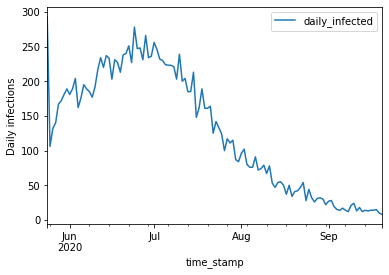

In [54]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

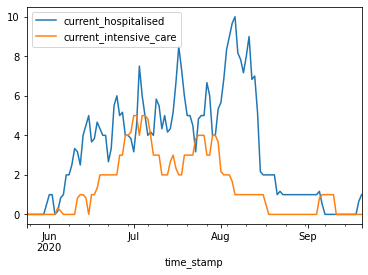

In [55]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [56]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-01-04 15:22:49,186 - june.records.records_reader - INFO - Loading infections table
2022-01-04 15:22:49,225 - june.records.records_reader - INFO - Loading population table
2022-01-04 15:22:49,290 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-04 15:22:49,300 - june.records.records_reader - INFO - Loading geography table
2022-01-04 15:22:49,331 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [57]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-01-04 15:22:49,352 - june.records.records_reader - INFO - Loading deaths table
2022-01-04 15:22:49,360 - june.records.records_reader - INFO - Loading population table
2022-01-04 15:22:49,421 - june.records.records_reader - INFO - Merging infection and population tables
2022-01-04 15:22:49,425 - june.records.records_reader - INFO - Loading geography table
2022-01-04 15:22:49,452 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [58]:
age_bins = (0,20,60,100)

In [59]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [60]:
people_df = read.table_to_df('population')

In [61]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

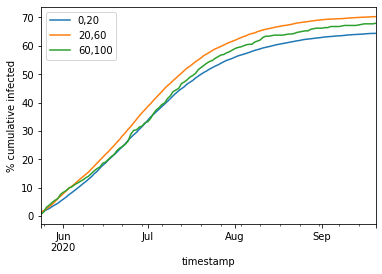

In [62]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [63]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

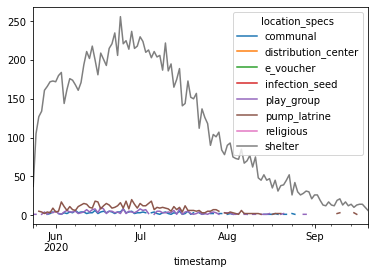

In [64]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

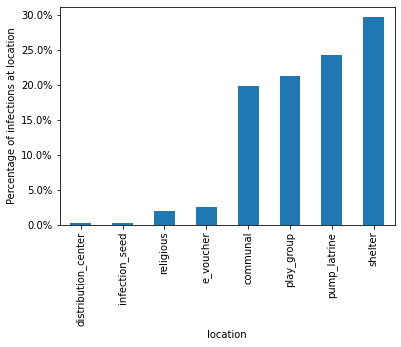

In [65]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')